In [111]:
import matplotlib
import matplotlib.pyplot as plt
import json
import copy
from types import SimpleNamespace
from matplotlib.ticker import FormatStrFormatter

def load_results(data):
    """Load results structure from JSON.

    Takes str, returns nested structure with SimpleNamespace instead of the
    default dictionary object. Use attribute access to access by key
    (not dict-like syntax).
    """
    return json.loads(data, object_hook=lambda d: SimpleNamespace(**d))


def load_results_from_file(filename):
    """Loads results from a JSON file.

    See :func:`load_results` for details.
    """
    with open(filename, "r", encoding="utf-8") as file:
        return load_results(file.read())

    
def join_results(results, prefixes=None, select=None, prefixes_as_labels=False):
    """Join multiple lists of results together

    The *results* argument either needs to be a list of result objects
    or an object with attribute *results* which is the list of result objects.
    This allows for results loaded from a file to be combined with a simple list.

    The function always returns just a simple list of result objects.
    """
    if not prefixes:
        prefixes = [None] * len(results)
    joined = []
    for result_list, prefix in zip(results, prefixes):
        if hasattr(result_list, "results"):
            # This is the actual list in the full results structure.
            result_list = result_list.results
        for result in result_list:
            if select and not select(result):
                continue
            result = copy.deepcopy(result)
            if prefix:
                if prefixes_as_labels:
                    result.label = prefix
                else:
                    result.label = f"{prefix}: {result.label}"
            joined.append(result)
    return joined


def join_results_from_files(
    source_filenames, prefixes=None, select=None, prefixes_as_labels=False
):
    """Join multiple files into one results object."""
    to_merge = []
    for result_file in source_filenames:
        to_merge.append(load_results_from_file(result_file))
    return join_results(
        to_merge,
        prefixes=prefixes,
        select=select,
        prefixes_as_labels=prefixes_as_labels,
    )

In [85]:
with open("/tmp/neighbors.json", "r", encoding="utf-8") as file:
    result = json.loads(file.read(), object_hook=lambda d: SimpleNamespace(**d)).results[0]

In [184]:
data = join_results_from_files(["/tmp/neighbors.json", "/tmp/neighbors2.json", "/tmp/neighbors3.json"])
result = data[0]
result2 = data[1]
result2.efficiency
result3 = data[2]
data

[namespace(all_times=[[217.98345184326172, 217.6505401134491, 218.04332423210144], [124.11687016487122, 122.06828784942627, 122.73294353485107], [92.91467452049255, 92.11091470718384, 92.2118649482727], [75.34897136688232, 75.59980535507202, 75.66735792160034], [63.04538059234619, 62.91978669166565, 63.14729356765747], [55.72632312774658, 55.84583497047424, 55.86688446998596], [50.70348763465881, 50.84022879600525, 51.3066782951355], [45.568519830703735, 46.54807424545288, 45.98758363723755], [43.693350076675415, 43.84098720550537, 44.266348123550415], [50.58323311805725, 40.937320709228516, 41.811687707901], [49.057507276535034, 49.431833267211914, 41.15949273109436], [43.24791097640991, 39.62877130508423, 37.893733739852905], [44.68847417831421, 42.17918014526367, 38.36304497718811], [43.08120131492615, 39.488385915756226, 39.57244801521301], [40.23399066925049, 38.65512681007385, 39.20244908332825], [38.78320050239563, 38.34165334701538, 38.96436905860901]], efficiency=[1.0, 0.88593

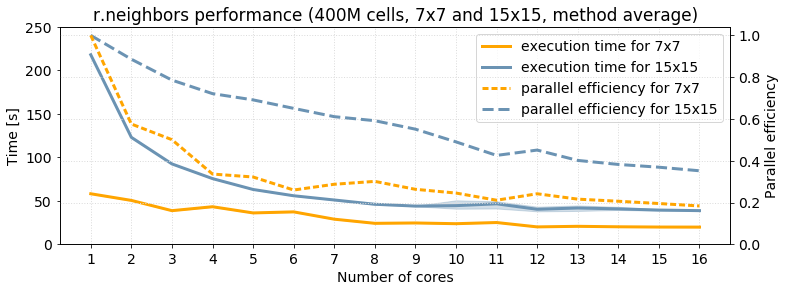

In [142]:

ax1 = plt.gca()
ax2 = ax1.twinx()
x_ticks = set()  # gather x values
x = result.nprocs
x_ticks.update(x)
ln2 = ax2.plot(x, result.efficiency, linestyle="--", linewidth=3, color="#6B93B3", label="parallel efficiency for 15x15")
ln3 = ax2.plot(x, result2.efficiency, linestyle="--", linewidth=3, color="#FFA500", label="parallel efficiency for 7x7", dashes=(2, 1))
ln1 = ax1.plot(x, result.times, label="execution time for 15x15",  linestyle="-", linewidth=3, color="#6B93B3")
ln4 = ax1.plot(x, result2.times, label="execution time for 7x7",  linestyle="-", linewidth=3, color="#FFA500")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))
if hasattr(result, "all_times"):
    mins = [min(i) for i in result.all_times]
    maxes = [max(i) for i in result.all_times]
    ax1.fill_between(x, mins, maxes, color="#6B93B3", alpha=0.3)
    #ax1.fill_between(x, mins, maxes, color="gray", alpha=0.3)

if hasattr(result2, "all_times"):
    mins = [min(i) for i in result2.all_times]
    maxes = [max(i) for i in result2.all_times]
    ax1.fill_between(x, mins, maxes, color="#FFA500", alpha=0.3)
    
#plt.legend()
    # If there is not many x values, show ticks for each, but use default
    # ticks when there is a lot of x values.
if len(x_ticks) < 10:
    ax1.set(xticks=sorted(x_ticks))
else:
    from matplotlib.ticker import (  # pylint: disable=import-outside-toplevel
        MaxNLocator,
    )
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xticks(list(range(1, 17)))
#ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
lns = ln4 + ln1 + ln3 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_xlabel("Number of cores")
ax1.set_ylabel("Time [s]")
ax2.set_ylabel('Parallel efficiency')
plt.title("r.neighbors performance (400M cells, 7x7 and 15x15, method average)")
ax2.grid(which='major', axis="both", color='#DCDCDC', linestyle=':', linewidth=1)
ax1.grid(which='major', axis="x", color='#DCDCDC', linestyle=':', linewidth=1)
ax1.set_ylim(bottom=0)
ax1.set_ylim(top=250)
ax2.set_ylim(bottom=0)
#plt.savefig("/tmp/benchmark.svg")
plt.show()


In [83]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['font.size'] = 14
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

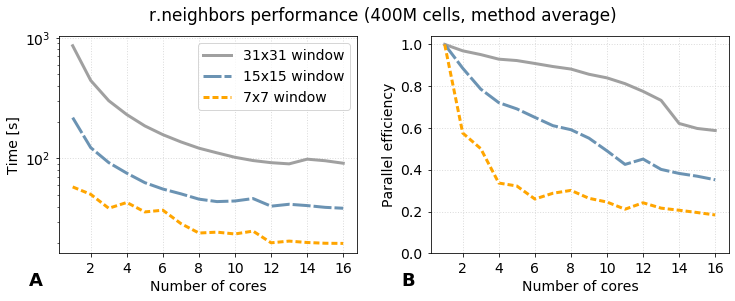

In [204]:
fig, (ax1, ax2) = plt.subplots(1, 2)
x_ticks = set()  # gather x values
x = result.nprocs
x_ticks.update(x)
ln3 = ax2.plot(x, result3.efficiency, linestyle="-", linewidth=3, color="#a0a0a0", label="31x31 window")
ln3 = ax2.plot(x, result.efficiency, linestyle="--", linewidth=3, color="#6B93B3", label="15x15 window", dashes=(6, 1))
ln4 = ax2.plot(x, result2.efficiency, linestyle="--", linewidth=3, color="#FFA500", label="7x7 window", dashes=(2, 1))

ln3 = ax1.plot(x, result3.times, label="31x31 window",  linestyle="-", linewidth=3, color="#a0a0a0")
ln1 = ax1.plot(x, result.times, label="15x15 window",  linestyle="--", linewidth=3, color="#6B93B3", dashes=(6, 1))
ln2 = ax1.plot(x, result2.times, label="7x7 window",  linestyle="--", linewidth=3, color="#FFA500", dashes=(2, 1))


ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))
if hasattr(result, "all_times"):
    mins = [min(i) for i in result.all_times]
    maxes = [max(i) for i in result.all_times]
   # ax1.fill_between(x, mins, maxes, color="#6B93B3", alpha=0.3)
    #ax1.fill_between(x, mins, maxes, color="gray", alpha=0.3)

if hasattr(result2, "all_times"):
    mins = [min(i) for i in result2.all_times]
    maxes = [max(i) for i in result2.all_times]
    #ax1.fill_between(x, mins, maxes, color="#FFA500", alpha=0.3)
    
if hasattr(result3, "all_times"):
    mins = [min(i) for i in result3.all_times]
    maxes = [max(i) for i in result3.all_times]
   # ax1.fill_between(x, mins, maxes, color="#969696", alpha=0.3)
    
#plt.legend()
    # If there is not many x values, show ticks for each, but use default
    # ticks when there is a lot of x values.
if len(x_ticks) < 10:
    ax1.set(xticks=sorted(x_ticks))
else:
    from matplotlib.ticker import (  # pylint: disable=import-outside-toplevel
        MaxNLocator,
    )
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax1.set_xticks(list(range(1, 17)))
#ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
lns = ln4 + ln1 + ln3 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(loc=0)
#ax2.legend(loc=0)
ax1.set_xlabel("Number of cores")
ax2.set_xlabel("Number of cores")
ax1.set_ylabel("Time [s]")
ax2.set_ylabel('Parallel efficiency')
fig.suptitle("r.neighbors performance (400M cells, method average)")
ax2.grid(which='major', axis="both", color='#DCDCDC', linestyle=':', linewidth=1)
ax1.grid(which='major', axis="both", color='#DCDCDC', linestyle=':', linewidth=1)
#ax1.set_ylim(bottom=0)
ax1.set_yscale("log")

ax2.set_ylim(bottom=0)

# set the spacing between subplots
plt.subplots_adjust(wspace=0.25)

ax1.text(-0.1, -0.15, "A", transform=ax1.transAxes, 
            size=18, weight='bold')
ax2.text(-0.1, -0.15, "B", transform=ax2.transAxes, 
            size=18, weight='bold')
plt.savefig("/tmp/benchmark.svg")
plt.show()
